# Customer Segmenation and Recommendation System

### 1. Import Libaries & Data Loading

In [229]:
#loading necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from collections import Counter

In [230]:
#loading the dataset
df = pd.read_csv("C:/Users/Gia Uyen/cusSeg.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [231]:
#checking the shape of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [232]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [233]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


### 2. Data Cleaning 

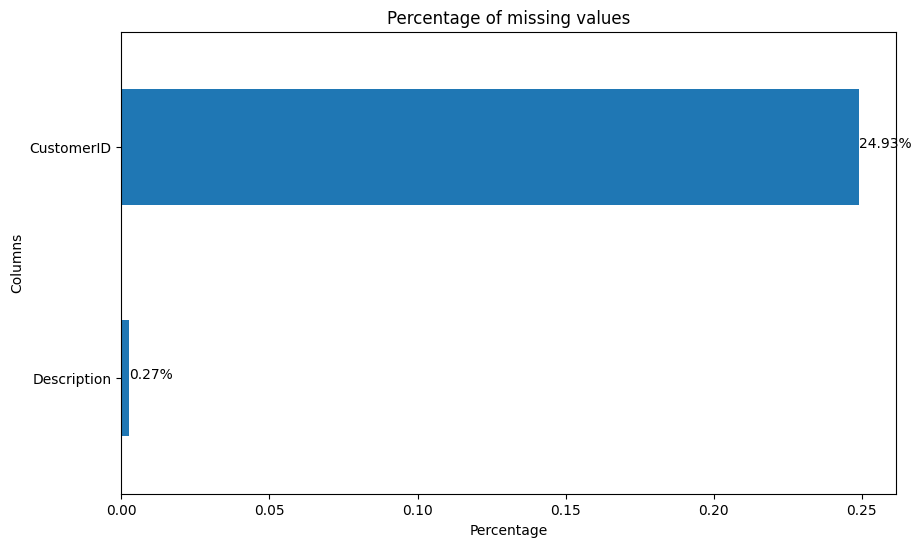

In [234]:
#find percentage of null values in each column & sort them in descending order
missing_percentage = df.isnull().sum()/df.shape[0]
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=True)

#create horizontal bar plot for missing values
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='barh')
plt.title('Percentage of missing values')
plt.xlabel('Percentage')
plt.ylabel('Columns')

#denote the missing percentage on the plot
for index, value in enumerate(missing_percentage):
    plt.text(value, index, f'{value:.2%}')



In [235]:
#remove missing values in the dataset
df = df.dropna(subset=['CustomerID','Description'])

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [236]:
#identified duplicated values
df[df.duplicated()] 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12/1/2010 11:49,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


In [237]:
#drop duplicated values
print('Number of duplicated rows:', df.duplicated().sum())

df.drop_duplicates(inplace=True)

Number of duplicated rows: 5225


In [238]:
#create status columns for transactions either "Cancelled" or "Valid"
df['Status'] = np.where(df['InvoiceNo'].str.contains('C'), 'Cancelled', 'Valid')

In [239]:
df[df['Status'] == 'Cancelled'].describe()

,Quantity,UnitPrice,CustomerID
count,8872.000000,8872.000000,8872.000000
mean,-30.774910,18.899512,14990.152953
std,1172.249902,445.190864,1708.230387
min,-80995.000000,0.010000,12346.000000
25%,-6.000000,1.450000,13505.000000
50%,-2.000000,2.950000,14868.000000
75%,-1.000000,4.950000,16393.000000
max,-1.000000,38970.000000,18282.000000


In [240]:
#find the percentage of cancelled transactions
cancelled_perc = (df[df['Status']=='Cancelled'].shape[0]/df.shape[0]) *100
print(f'Cancelled Percentage: {cancelled_perc: .2f}%')

Cancelled Percentage:  2.21%


In [241]:
#find the number of products in the dataset
stock_code = df['StockCode'].nunique()
stock_code

3684

Text(0, 0.5, 'Stock Code')

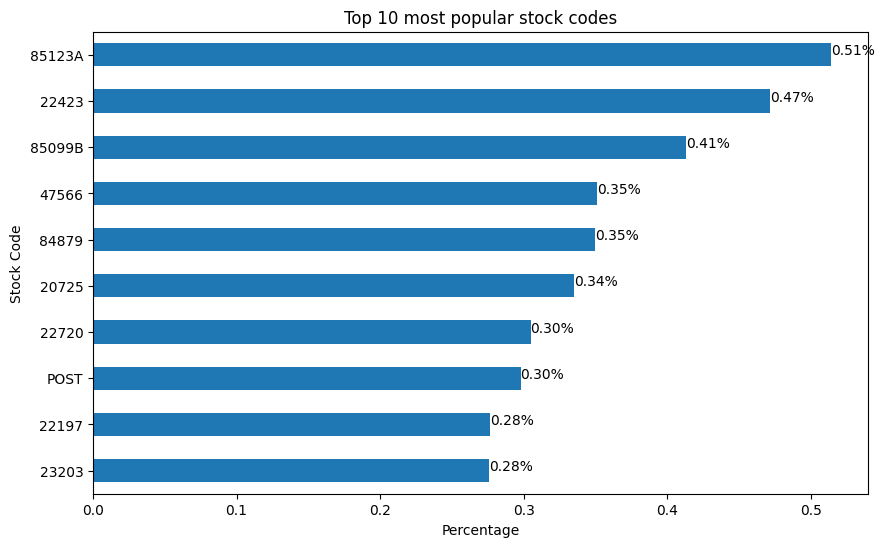

In [242]:
#find the top 10 most popular stock codes
top10_stock = df['StockCode'].value_counts(normalize=True).head(10).sort_values() *100
top10_stock.plot(kind='barh', figsize=(10, 6))

for i, v in enumerate(top10_stock):
    plt.text(v,i, f'{v:.2f}%')
plt.title('Top 10 most popular stock codes')
plt.xlabel('Percentage')
plt.ylabel('Stock Code')


In [243]:
df[df['StockCode'] == '85123A'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,Valid
49,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 9:02,2.55,17850.0,United Kingdom,Valid
66,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 9:32,2.55,17850.0,United Kingdom,Valid
220,536390,85123A,WHITE HANGING HEART T-LIGHT HOLDER,64,12/1/2010 10:19,2.55,17511.0,United Kingdom,Valid
262,536394,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,12/1/2010 10:39,2.55,13408.0,United Kingdom,Valid


In [244]:
count = 0
for c in df['StockCode'].unique():
    if c.isdigit() == False:
        print(c)
    else:
        pass


85123A
84406B
84029G
84029E
POST
82494L
85099C
84997B
84997C
84519A
85183B
85071B
37444A
37444C
84971S
15056BL
15056N
D
35004C
85049A
85099B
35004G
85014B
85014A
84970S
84030E
35004B
85049E
17091A
84509A
84510A
84709B
84625C
84625A
47570B
85049C
85049D
85049G
84970L
90199C
90129F
90210B
72802C
85169B
85099F
85184C
35591T
84032B
85049H
72800E
84849B
90200B
90059B
90185C
90059E
90059C
90200C
90200D
90200A
16258A
85231B
85231G
48173C
47563A
84558A
46000M
71406C
84985A
84596E
84997D
47599A
47599B
85035B
84968C
72800B
84563A
47504H
17164B
15044B
84569B
85114B
85114C
85199L
85199S
85019A
85019C
85071A
85071C
85135B
85136A
85136C
C2
79144B
46000R
46000S
84508A
85232B
79066K
84884A
51014C
51014L
51014A
79302M
84509B
84870C
84870B
M
85032D
84760S
35598D
35598B
15056P
84032A
84031A
84997A
90214M
90214V
90214S
90214J
72807C
47591B
85035C
72803A
85034A
72798C
35271S
47567B
72760B
62096A
85071D
79191C
84031B
47566B
47590B
47590A
85061W
47591D
84341B
84509G
84846A
85132A
85132B
85132C
85159A
17090D


In [245]:
#find unusual stock codes
unsual_stock = [stock for stock in df['StockCode'].unique() if sum(s.isdigit() for s in str(stock)) in (0,1)]
print(df[df['StockCode'].isin(unsual_stock)]['StockCode'].value_counts())
unsual_stock_perc = df['StockCode'].isin(unsual_stock).sum() / df.shape[0] * 100
print(f'Percentage of unusual stock codes: {unsual_stock_perc:.2f}%')

StockCode
POST            1196
M                460
C2               134
D                 77
DOT               16
CRUK              16
BANK CHARGES      12
PADS               4
Name: count, dtype: int64
Percentage of unusual stock codes: 0.48%


In [246]:
#remove unusual stock codes
df = df[~df['StockCode'].isin(unsual_stock)]

Text(0, 0.5, 'Item Description')

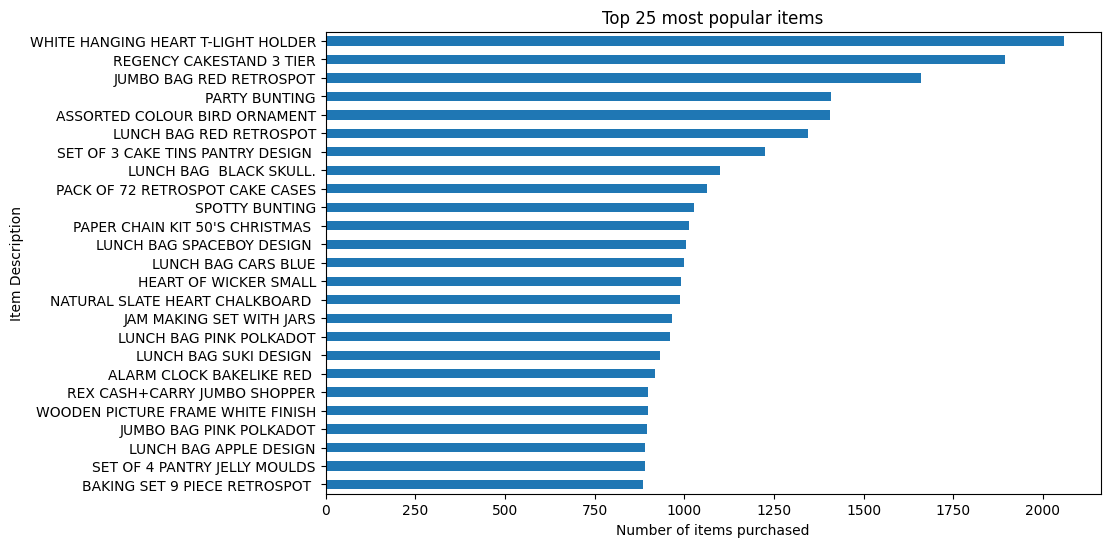

In [247]:
#Top 25 popular items
top25_stock = df['Description'].value_counts().head(25).sort_values()  
top25_stock.plot(kind='barh', figsize=(10, 6))
plt.title('Top 25 most popular items')
plt.xlabel('Number of items purchased')
plt.ylabel('Item Description')

Household items, especialy kitchenware and decorative items, are usually purchased the most. White hanging heart T-light holder is the most popular item that is bought over 2000 times. The majority of the top 25 popular items are purchased roughly between 900 and 1000 times. 

In [248]:
#Check if there is any transaction with zero price.
df[df['UnitPrice']==0].describe()[['Quantity']]

#There are only 33 transactions with zero price, but their quantity of items vary by a signiicant number from 1 up to 12450, so it's best to remove them to maintain a clean and consistent dataset.
df = df[df['UnitPrice'] > 0]

### 3. Feature Engineering

In [249]:
#create a dataframe specifically for customer-centric features
customer = pd.DataFrame(df['CustomerID'].unique(), columns=['CustomerID'])

Cancellation Patterns

In [250]:
#find number of cancelled orders per customer
cancelled_orders = df[df['Status'] == 'Cancelled'].groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

#find number of total orders per customer
total_orders = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

#add cancelled orders and total orders to the customer dataframe
customer = customer.merge(total_orders, on='CustomerID', how='left').rename(columns={'InvoiceNo':'TotalOrders'})
customer = customer.merge(cancelled_orders, on='CustomerID', how='left').rename(columns={'InvoiceNo':'CancelledOrders'})
customer['CancelledOrders'].fillna(0, inplace=True)

#calculate the percentage of cancelled orders
customer['CancelledOrdersPercentage'] = round(customer['CancelledOrders']/customer['TotalOrders'],2) 
customer

,CustomerID,TotalOrders,CancelledOrders,CancelledOrdersPercentage
0,17850.0,35,1.0,0.03
1,13047.0,16,7.0,0.44
2,12583.0,17,2.0,0.12
3,13748.0,5,0.0,0.00
4,15100.0,6,3.0,0.50
...,...,...,...,...
4357,13436.0,1,0.0,0.00
4358,15520.0,1,0.0,0.00
4359,13298.0,1,0.0,0.00
4360,14569.0,1,0.0,0.00


#### Create customer-centric features from the dataset 
Creating RFM (Recency, Frequency, Monetary) Features
> Recency: How recently a customer has made a purchase \
> Frequency: How often a customer makes a purchase \
> Monetary: How much money a customer spends on purchases

In [251]:
#Recency
# Convert InvoiceDate to datetime type & extract only the date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

# Calculate the number of days since the last purchase for each customer
df['difference'] = (df['InvoiceDate'].max() - df['InvoiceDate'])
recency = df.groupby('CustomerID')['difference'].min().reset_index()

# Add recency to the customer dataframe
customer = customer.merge(recency, on='CustomerID', how='left').rename(columns={'difference':'Recency'})

del df['difference']

In [252]:
#Frequency

#Total products purchased per customer
total_products = df.groupby('CustomerID')['Quantity'].sum().reset_index() 

#Add total products to the customer dataframe
customer = customer.merge(total_products, on='CustomerID', how='left').rename(columns={'Quantity':'TotalProducts'})
customer

,CustomerID,TotalOrders,CancelledOrders,CancelledOrdersPercentage,Recency,TotalProducts
0,17850.0,35,1.0,0.03,302 days 00:00:00,1696
1,13047.0,16,7.0,0.44,46 days 00:00:00,1355
2,12583.0,17,2.0,0.12,2 days 00:00:00,4978
3,13748.0,5,0.0,0.00,95 days 00:00:00,439
4,15100.0,6,3.0,0.50,330 days 00:00:00,58
...,...,...,...,...,...,...
4357,13436.0,1,0.0,0.00,1 days 00:00:00,76
4358,15520.0,1,0.0,0.00,1 days 00:00:00,314
4359,13298.0,1,0.0,0.00,1 days 00:00:00,96
4360,14569.0,1,0.0,0.00,1 days 00:00:00,79


In [253]:
#Monetary

#Total amount spent by each customer
df['Total_Spent'] = df['Quantity'] * df['UnitPrice']
Total_Spent = df.groupby('CustomerID')['Total_Spent'].sum().reset_index()

#Add total amount spent to the customer dataframe
customer = customer.merge(Total_Spent, on='CustomerID', how='left')

#Average amount spent on each transaction by each customer
customer['Average_Spent'] = customer['Total_Spent'] / customer['TotalOrders']
customer


,CustomerID,TotalOrders,CancelledOrders,CancelledOrdersPercentage,Recency,TotalProducts,Total_Spent,Average_Spent
0,17850.0,35,1.0,0.03,302 days 00:00:00,1696,5303.48,151.528000
1,13047.0,16,7.0,0.44,46 days 00:00:00,1355,3089.10,193.068750
2,12583.0,17,2.0,0.12,2 days 00:00:00,4978,6629.34,389.961176
3,13748.0,5,0.0,0.00,95 days 00:00:00,439,948.25,189.650000
4,15100.0,6,3.0,0.50,330 days 00:00:00,58,635.10,105.850000
...,...,...,...,...,...,...,...,...
4357,13436.0,1,0.0,0.00,1 days 00:00:00,76,196.89,196.890000
4358,15520.0,1,0.0,0.00,1 days 00:00:00,314,343.50,343.500000
4359,13298.0,1,0.0,0.00,1 days 00:00:00,96,360.00,360.000000
4360,14569.0,1,0.0,0.00,1 days 00:00:00,79,227.39,227.390000


In [254]:
#create unique products purchased per customer
unique_products = df.groupby('CustomerID')['StockCode'].nunique().reset_index()

#add unique products to the customer dataframe
customer = customer.merge(unique_products, on='CustomerID', how='left').rename(columns={'StockCode':'UniqueProducts'})
customer

,CustomerID,TotalOrders,CancelledOrders,CancelledOrdersPercentage,Recency,TotalProducts,Total_Spent,Average_Spent,UniqueProducts
0,17850.0,35,1.0,0.03,302 days 00:00:00,1696,5303.48,151.528000,24
1,13047.0,16,7.0,0.44,46 days 00:00:00,1355,3089.10,193.068750,105
2,12583.0,17,2.0,0.12,2 days 00:00:00,4978,6629.34,389.961176,114
3,13748.0,5,0.0,0.00,95 days 00:00:00,439,948.25,189.650000,24
4,15100.0,6,3.0,0.50,330 days 00:00:00,58,635.10,105.850000,1
...,...,...,...,...,...,...,...,...,...
4357,13436.0,1,0.0,0.00,1 days 00:00:00,76,196.89,196.890000,12
4358,15520.0,1,0.0,0.00,1 days 00:00:00,314,343.50,343.500000,18
4359,13298.0,1,0.0,0.00,1 days 00:00:00,96,360.00,360.000000,2
4360,14569.0,1,0.0,0.00,1 days 00:00:00,79,227.39,227.390000,10


In [255]:
customer['Recency'] = customer['Recency'].astype('str') 
customer['Recency'] = customer['Recency'].str.split(' ').str[0]
customer['Recency'].head()


0    302
1     46
2      2
3     95
4    330
Name: Recency, dtype: object

### 4. Outlier Removal, Correlation Analysis & Data Scaling

#### Outlier Removal

In [256]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer['Outlier_Scores'] = model.fit_predict(customer.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer['Is_Outlier'] = [1 if x == -1 else 0 for x in customer['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer.head()

,CustomerID,TotalOrders,CancelledOrders,CancelledOrdersPercentage,Recency,TotalProducts,Total_Spent,Average_Spent,UniqueProducts,Outlier_Scores,Is_Outlier
0,17850.0,35,1.0,0.03,302,1696,5303.48,151.528000,24,-1,1
1,13047.0,16,7.0,0.44,46,1355,3089.10,193.068750,105,1,0
2,12583.0,17,2.0,0.12,2,4978,6629.34,389.961176,114,1,0
3,13748.0,5,0.0,0.00,95,439,948.25,189.650000,24,1,0
4,15100.0,6,3.0,0.50,330,58,635.10,105.850000,1,1,0


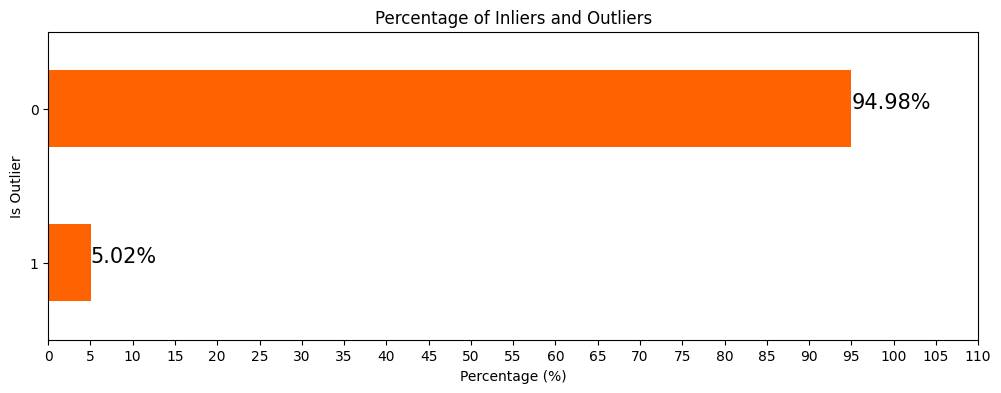

In [257]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [258]:
# Remove the outliers from the main dataset
customer = customer[customer['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer = customer.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer.reset_index(drop=True, inplace=True)

#### Correlation Analysis

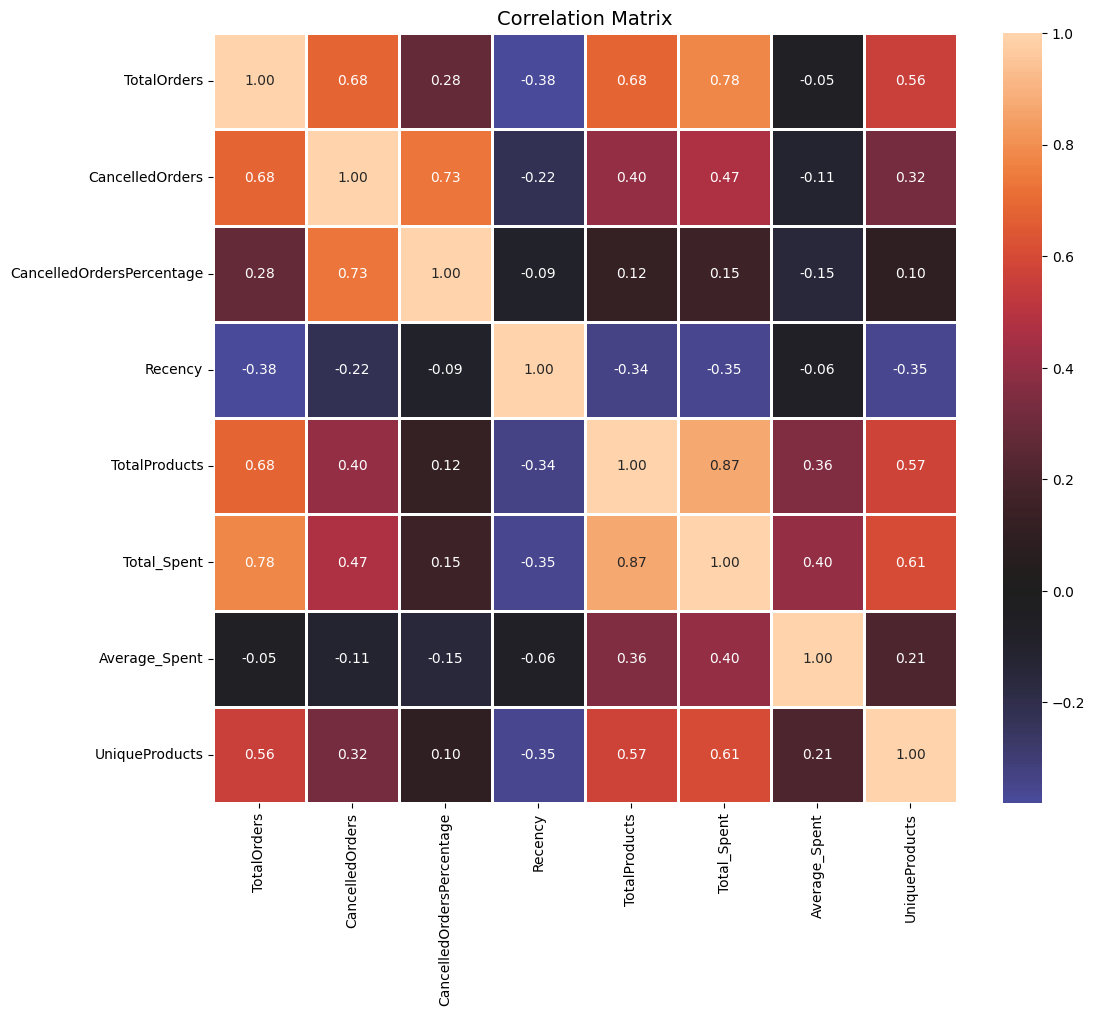

In [259]:
corr = customer.drop(columns=['CustomerID']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

#### Feature Scaling

In [260]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that need to be scaled
columns_to_scale = customer.columns.difference(['CustomerID'])

# Copy the cleaned dataset
customer_scaled = customer.copy()

# Applying the scaler to the necessary columns in the dataset
customer_scaled[columns_to_scale] = scaler.fit_transform(customer_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_scaled.head()

,CustomerID,TotalOrders,CancelledOrders,CancelledOrdersPercentage,Recency,TotalProducts,Total_Spent,Average_Spent,UniqueProducts
0,13047.0,2.940422,6.027537,2.139796,-0.468432,0.817794,1.523313,-0.437461,0.895941
1,12583.0,3.184725,1.342694,0.147244,-0.910333,5.116778,4.235010,0.452725,1.053668
2,13748.0,0.253089,-0.531243,-0.599963,0.023684,-0.269115,-0.116502,-0.452918,-0.523604
3,15100.0,0.497392,2.279663,2.513399,2.383833,-0.721202,-0.356364,-0.831793,-0.926685
4,15291.0,3.673331,4.153600,1.018986,-0.679339,1.669759,2.643467,-0.227297,0.142355


### 5. PCA (Principle Component Analysis)

Text(0, 0.5, 'cumulative explained variance')

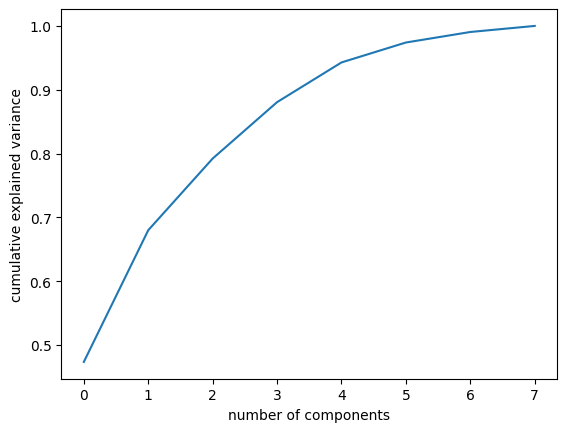

In [261]:
customer_scaled.set_index('CustomerID', inplace=True)

#apply PCA to reduce the dimensionality of the dataset
pca = PCA().fit(customer_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')


Based on the graph, the optimal number of components is 6.

In [262]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_pca = pca.fit_transform(customer_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_pca = pd.DataFrame(customer_pca, columns=['PC1','PC2','PC3','PC4','PC5','PC6'])

# Adding the CustomerID index back to the new PCA dataframe
customer_pca.index = customer_scaled.index

customer_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
13047.0,5.391322,4.018505,0.986934,0.107161,-0.392381,-2.230156
12583.0,6.839042,-1.414953,0.314246,1.555927,-2.182890,1.458611
13748.0,-0.624624,-0.150189,-0.541775,0.453758,-0.512694,-0.124983
15100.0,0.004253,3.608247,2.427233,0.742989,-0.032221,-0.418233
15291.0,5.516612,2.141087,0.441264,0.830679,-1.819014,-1.623751


### 6. Clusing Analysis using K-Means

#### Elbow Method

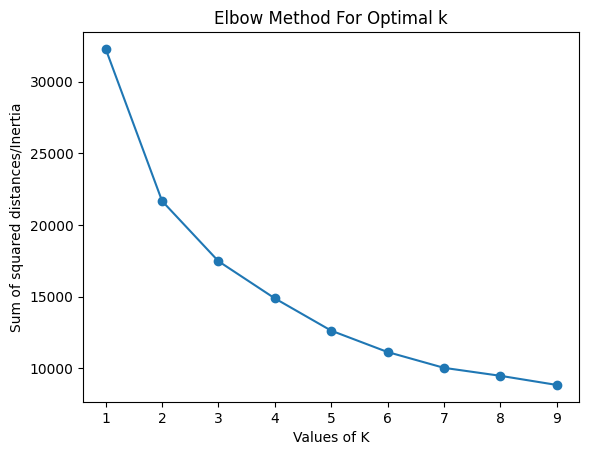

In [263]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(customer_pca)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,marker='o')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

#### K-Means Clustering

In [264]:
# k means using 3 clusters and k-means++ initialization
kmeans = KMeans(n_clusters = 3, init='k-means++')
kmeans.fit(customer_pca)
pred = kmeans.predict(customer_pca)

customer_pca = pd.DataFrame(customer_pca)
customer_pca['cluster'] = pred
customer['Cluster'] = pred
customer_pca['cluster'].value_counts()

cluster
1    2603
0     914
2     626
Name: count, dtype: int64

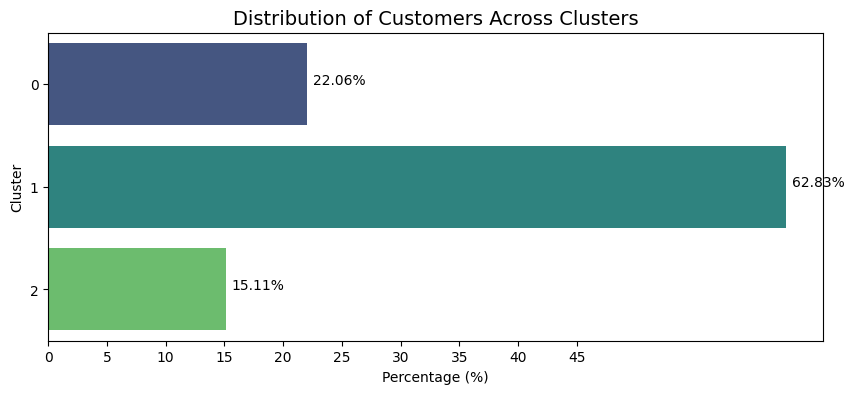

In [265]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette='viridis')

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

#### Evaluation Metrics

In [266]:
# Compute number of customers
num_observations = len(customer_pca)

# Separate the features and the cluster labels
X = customer_pca.drop('cluster', axis=1)
clusters = customer_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(pd.DataFrame((table_data), columns=['Metric', 'Value']))

                    Metric        Value
0   Number of Observations  4143.000000
1         Silhouette Score     0.332783
2  Calinski Harabasz Score  1755.057449
3     Davies Bouldin Score     1.214793


#### Customer Profile based on Clusing Analysis

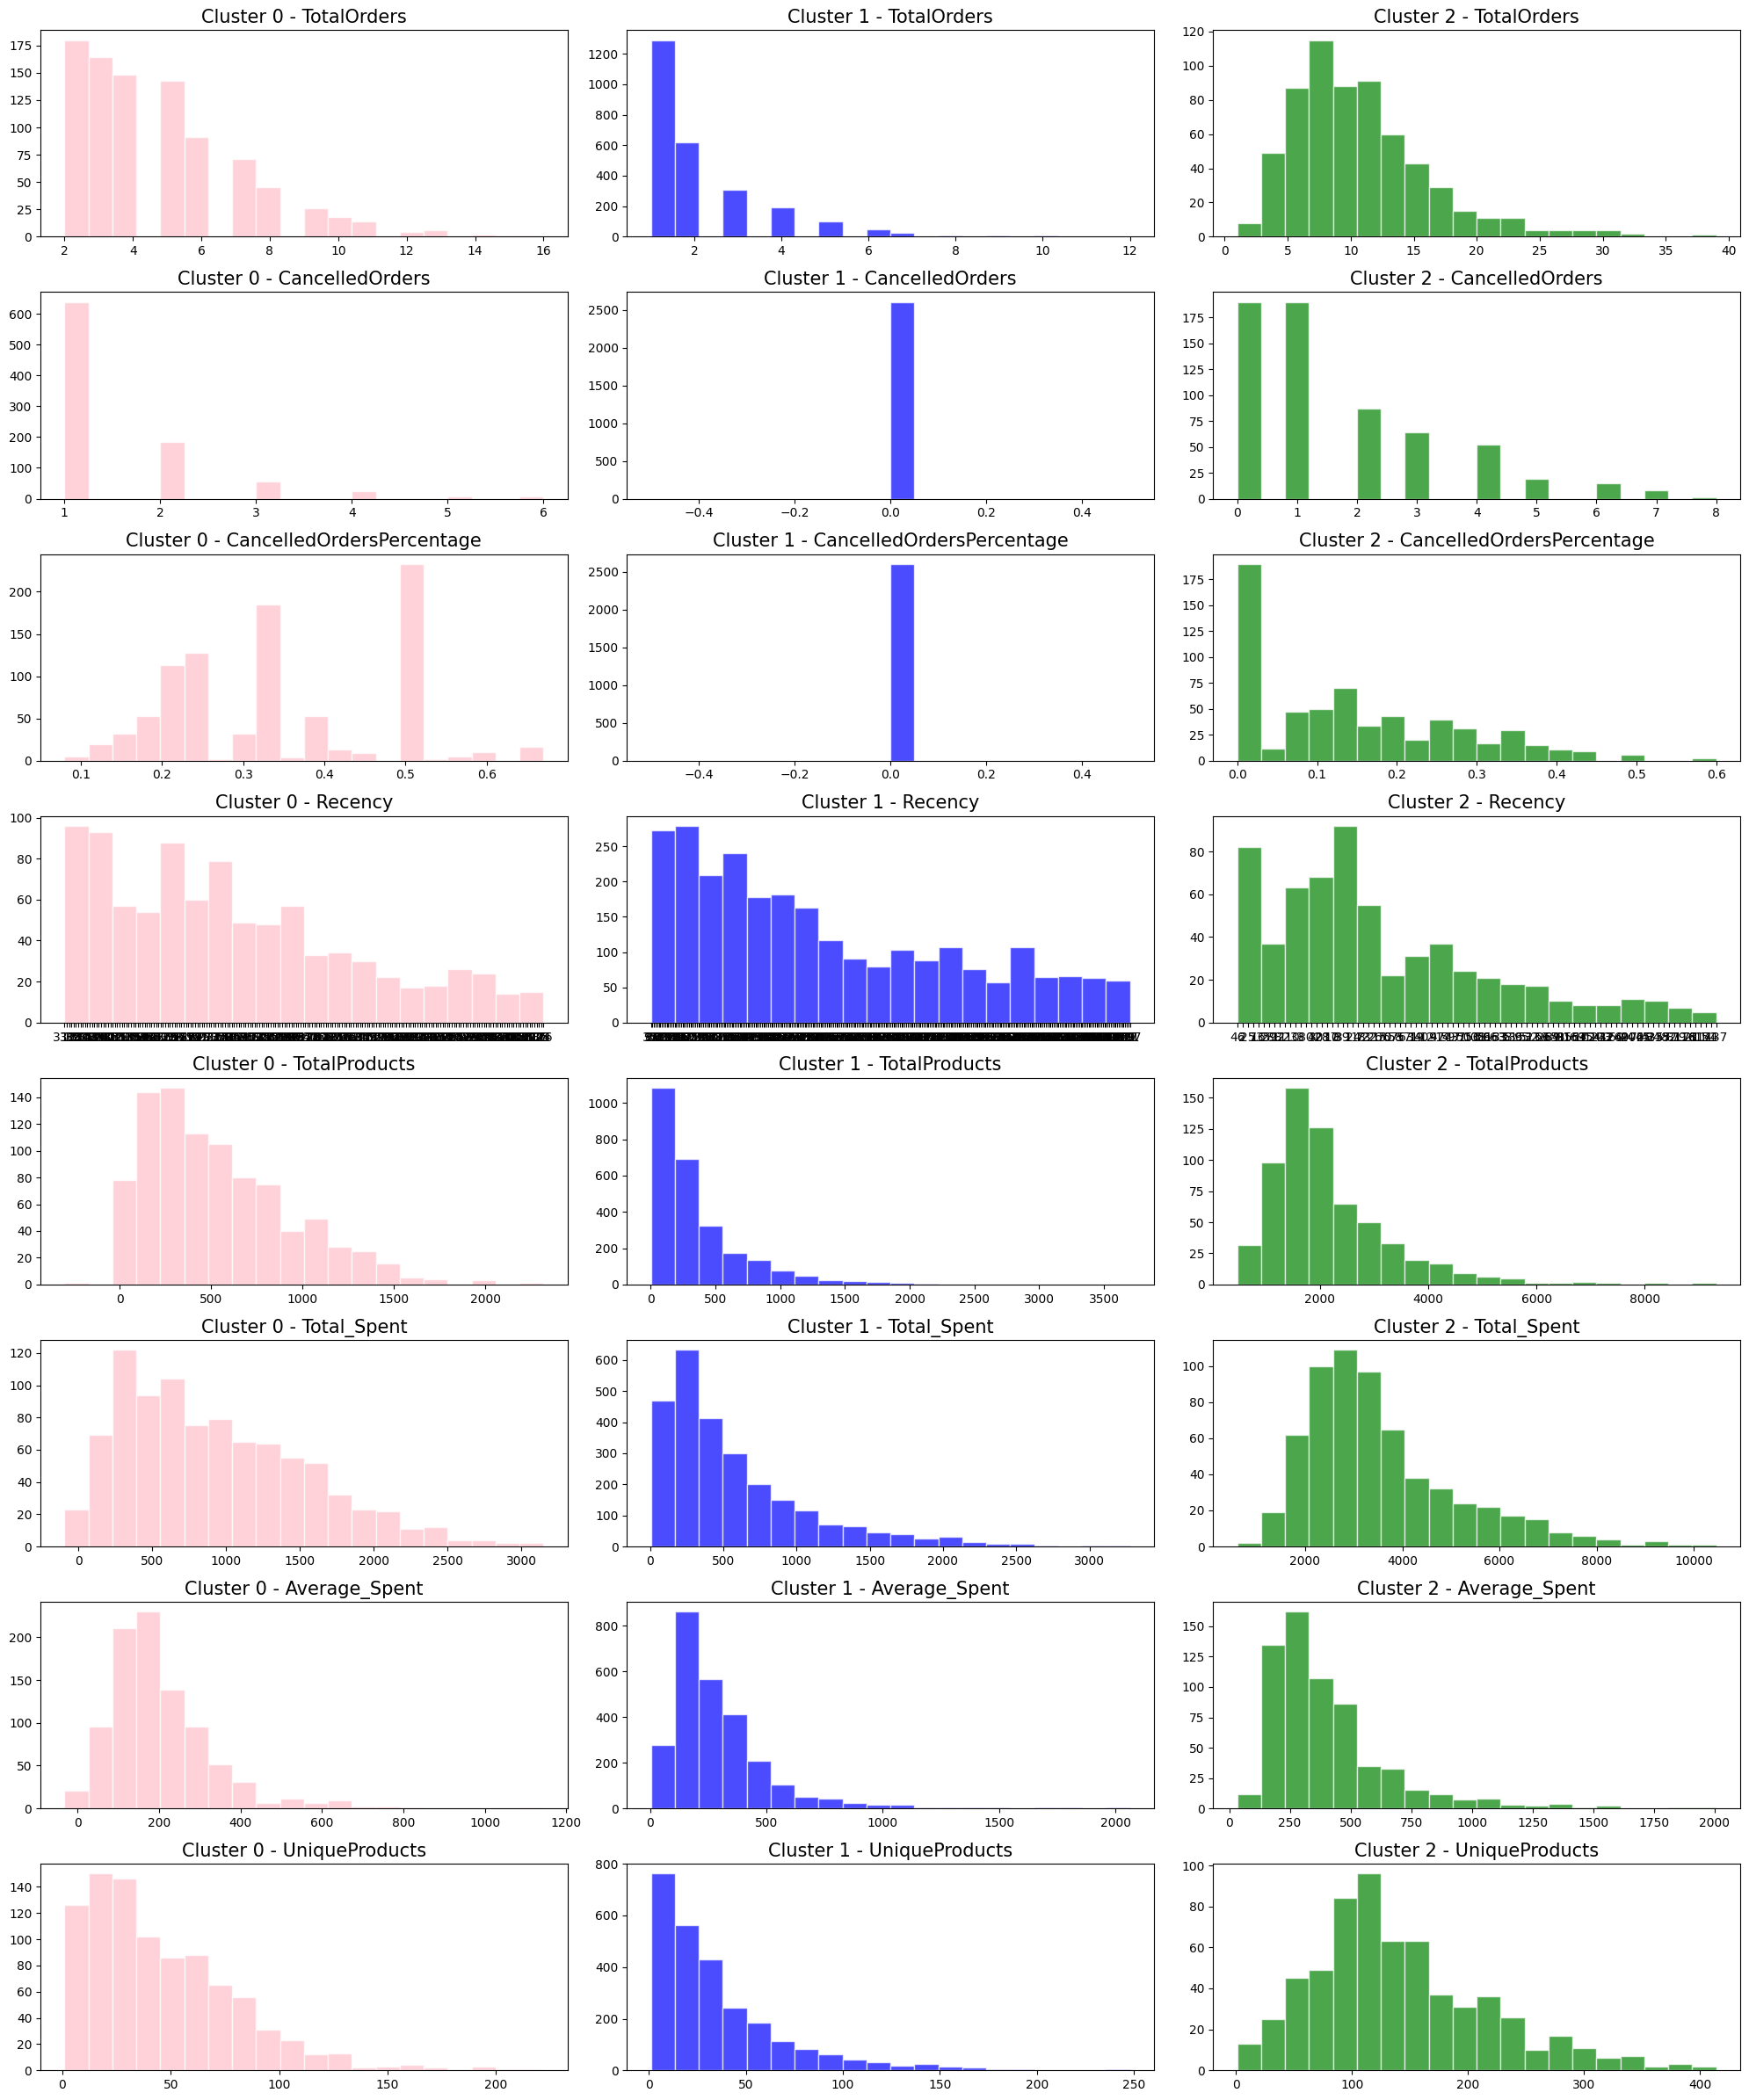

In [267]:
colors = ['pink','blue','green']

# Plot histograms for each feature segmented by the clusters
features = customer.columns[1:-1]
clusters = customer['Cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# If there's only one row or one column, make axes a 2D array for consistency
if n_rows == 1:
    axes = np.expand_dims(axes, axis=0)  # Make it 2D with 1 row
if n_cols == 1:
    axes = np.expand_dims(axes, axis=1)  # Make it 2D with 1 column

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer[customer['Cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color = colors[j], edgecolor='w',alpha=0.7,)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()


### 7. Recommendation System

In [291]:
df_filtered = df[df['CustomerID'].isin(customer['CustomerID'])]

merged_data = df_filtered.merge(customer[['CustomerID', 'Cluster']], on='CustomerID', how='inner')

best_selling_products = merged_data.groupby(['Cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['Cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('Cluster').head(10)

customer_purchases = merged_data.groupby(['CustomerID', 'Cluster', 'StockCode'])['Quantity'].sum().reset_index()

In [292]:
recommendations = []
for clus in range(0,3):
    top_products = top_products_per_cluster[top_products_per_cluster['Cluster'] == clus]
    customers_in_cluster = customer[customer['Cluster'] == clus]['CustomerID']
    
    for c in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == c) & 
                                                         (customer_purchases['Cluster'] == clus)]['StockCode'].tolist()
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendations.append([c, clus] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())
        
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'Cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])

customer_data_with_recommendations = customer.merge(recommendations_df, on=['CustomerID', 'Cluster'], how='right')

In [301]:
recommendations_df.sample(10, random_state=42)

,CustomerID,Cluster,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
2351,13080.0,1,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85099B,JUMBO BAG RED RETROSPOT
1966,13570.0,1,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1582,18151.0,1,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85099B,JUMBO BAG RED RETROSPOT
296,15365.0,0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,22492,MINI PAINT SET VINTAGE,21212,PACK OF 72 RETROSPOT CAKE CASES
149,16503.0,0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER
2567,13277.0,1,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85099B,JUMBO BAG RED RETROSPOT
1610,13666.0,1,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85099B,JUMBO BAG RED RETROSPOT
1644,17770.0,1,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85099B,JUMBO BAG RED RETROSPOT
1815,17733.0,1,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85099B,JUMBO BAG RED RETROSPOT
3712,15854.0,2,85099B,JUMBO BAG RED RETROSPOT,22616,PACK OF 12 LONDON TISSUES,16014,SMALL CHINESE STYLE SCISSOR
